# ABCM Computer lab 4: Variation & Convergence in Populations

In this computer lab, we will explore the agent-based model described in Mudd, K., de Vos, C., & de Boer, B. (2022). Shared Context Facilitates Lexical Variation in Sign Language Emergence. Languages, 7(1), Article 1. [https://doi.org/10.3390/languages7010031](https://doi.org/10.3390/languages7010031)

Below, we use the Python code written by the first author Katie Mudd herself, which she shared openly on Figshare: [https://doi.org/10.6084/m9.figshare.15163872.v1](https://doi.org/10.6084/m9.figshare.15163872.v1)

This code makes use of the [Mesa](https://mesa.readthedocs.io/en/latest/) package, which is a Python framework for agent-based modelling. It allows users to quickly create agent-based models using built-in core components (such as spatial grids and agent schedulers) or customized implementations. The code below uses four classes from the Mesa package:

- ```Agent```
- ```Model```
- ```RandomActivation```
- ```DataCollector```

The generic ```Agent``` and ```Model``` class from the Mesa package are built upon in the code below (using [class inheritance](https://www.w3schools.com/python/python_inheritance.asp)) to create the specific type of agent needed for this model (called ```ContextAgent``` below), and the specific type of model needed (called ```ContextModel``` below). Using such a child class of the parent class ```Model```, the code can then use the built-in ```RandomActivation``` and ```DataCollector``` classes from the Mesa package to schedule the agents' interactions and keep track of various measures of the population's interactions and vocabularies.

If you've created a virtual environment for this course before, **don't forgot to activate your virtual environment** before running this notebook. (Activate your virtual environment from the terminal, then type ```jupyter notebook``` in the terminal to open Jupyter notebooks in the browser, then open the notebook for this computer lab, and do Kernel --> Change kernel --> ```<myenv>```, where ```<myenv>``` is the name of your virtual environment.

Let's first install the Mesa package:

In [1]:
pip install mesa

Note: you may need to restart the kernel to use updated packages.


Then, let's import all the packages, classes and functions we'll need:

In [2]:
import random
import numpy as np
import itertools
from math import sqrt
import time
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
from mesa.batchrunner import BatchRunner, FixedBatchRunner
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Parameter settings:

The code cell below contains the parameter settings that we'll need to run simulations further down in the notebook. Below, these parameters are combined in a dictionary, which is the datastructure that the code below expects when retrieving these parameter settings.

In [3]:
################# PARAMETER SETTINGS: ################# 

test_params = dict(
    n_concepts=10, # int: number of concepts
    n_bits=10,  # int: number of bits (determining length of forms and culturally-salient feature vectors)
    n_agents=10, # int: number of agents in the population
    n_groups=1,  # determines how many different semantic groups there are
    initial_degree_of_overlap=0.9,  # degree of overlap between the form and meaning components
    n_steps=2000  # number of timesteps to run the simulation for (called "model stages" in the paper)
)

## Initialising the population and their language representations

As described on page 7 of Mudd et al. (2022) (see **Initialization** paragraph), each agent in the population has a language representation that consists of ```n_concepts``` concepts, where each concept is associated with (i) a set of culturally salient features, and (ii) a form. The set of culturally salient features and the form both consist of ```n_bits``` bits. (Also see Figure 4 in the paper.)

The vector of culturally salient features represents the _meaning_ of the concept to the agent (which depends on their cultural background; i.e., the group they belong to). The form vector represents the _form_ (i.e., signal) that the agent would use in order to convey that concept.
The parameter ```initial_degree_of_overlap``` determines the degree of overlap between the culturally salient features vector and the form. If this degree of overlap is high, that simulates a form that is highly _iconic_ (i.e., when aspects of the form resemble aspects of the meaning).

The code in this section takes care of initialising the population and each agent's language representations, depending on which group in the population they belong to.

This is done using the following four functions:
- ```language_skeleton()```: Creates an empty language representation for an agent (where the meaning and form components are initialised with the value ```None```)
- ```language_create_meanings()```: Randomly generates a bit vector of culturally-salient features for each concept, for each group in the population
- ```language_add_meaning()```: Takes a particular agent object, and fills in the meaning vectors in its empty language representation with the bit vectors of culturally-salient features that correspond to the group that the agent belongs to
- ```language_add_form()```: Takes a particular agent object, and fills in the form vectors in its empty language representation, depending on the setting of the ```initial_degree_of_overlap``` parameter, which determines the probability that a given bit of a meaning and form representation are the same (i.e., have the same value at the same index). (See top of page 9 in Mudd et al., 2022.)

In [4]:
def language_skeleton(n_concepts, n_bits):
    """ initiate language with n_concepts and n_bits
    in the form {0: [meaning, form], 1: [meaning, from], ...}
    the meaning and form components are initiated with None """
    skeleton_concept_meaning_form = {}
    for n in range(n_concepts):
        skeleton_concept_meaning_form[n] = [[None] * n_bits] * 2
    return skeleton_concept_meaning_form

In [5]:
def language_create_meanings(n_concepts, n_bits, n_groups):
    """ generate the meaning representation for each group
    returns a dictionary with group: meaning representation
    ex. {0: [[1, 1, 0, 1, 1], [0, 0, 0, 1, 0]], 1: [[0, 0, 0, 1, 1], [1, 1, 1, 1, 0]]} """
    group_meaning_dic = {}
    for n in range(n_groups):
        condition = False
        while condition == False:
            single_group_meaning_list = []
            for concept in range(n_concepts):
                single_group_meaning_list.append(random.choices([0, 1], k=n_bits))  # list of len n_components
            if len(set(tuple(row) for row in single_group_meaning_list)) == len(
                    single_group_meaning_list):
                condition = True
                group_meaning_dic[n] = single_group_meaning_list
                
    return group_meaning_dic

In [6]:
def language_add_meaning(agent, meaning_dic):
    """ takes in the language skeleton and adds the meaning component depending on group of agent """
    counter = 0  # to keep track of which meaning component in meaning_dic values
    for concept, meaning_form in agent.language_rep.items():
        meaning_form[0] = meaning_dic[agent.group][counter]  # meaning_form[0] is the meaning only
        counter += 1
    return agent

In [7]:
def language_add_form(agent, initial_degree_of_overlap):
    """ start with meaning representation and assign form representation
    depending on the desired degree of overlap """
    for concept, meaning_form in agent.language_rep.items():
        forms = []
        for bit in meaning_form[0]:
            my_choice = np.random.choice([True, False], p=[initial_degree_of_overlap, 1 - initial_degree_of_overlap])  # p = weights
            if not my_choice:  # if my_choice == False
                random_choice = np.random.choice([0, 1])
                forms.append(random_choice)  # random choice 0 or 1 if False (random)
            else:
                forms.append(bit)  # append the same bit (iconic)
        meaning_form[1] = forms
    return agent

## Running a language game and updating the agents' language representations

As described in pages 9-10 and Figure 5 of Mudd et al. (2022), there are four different stages that a sender-receiver pair can go through in a language game interaction:

1. _signal production_: First, the sender randomly chooses a concept and produces the corresponding form given by the sender's language representation (this form is the signal that the sender produces).

2. _form success_: The receiver finds the form which is closest to the sender's form in the receiver's language representation (by calculating the distance between the sender's form to all forms of the receiver, and choosing the form with the smallest distance). If the concept for that form in the receiver's language representation is the same as the concept that the sender wanted to convey, the pair has achieved _form success_ (by using the _conventional link_ between a concept and a form). If the pair has achieved _form success_, the language game ends here.

3. _culturally salient features success_: If the pair has _not_ achieved _form success_, the receiver now tries to make use of the _iconic–inferential pathway_ (where a form and concept are linked via the culturally salient features) in order to interpret the sender's signal (see Figure 2 in Mudd et al., 2022). The receiver does this by comparing the sender's form to all sets of culturally salient features in the receiver's language representation (again by calculating the distance and choosing the concept that has the smallest distance to the sender's form). If the concept chosen in this way is the same as the concept that the sender wanted to convey, the pair has achieved _culturally salient features success_, and the game ends here.

4. _bit update_: If the pair has achieved neither _form success_ nor _culturally salient features success_, the receiver proceeds by updating the form that they associate with the concept that the sender wanted to convey. The receiver does this by updating one bit of their form which is different from the form of the sender.

The five functions below take care of the following:

- ```language_game()```: Iterates over all agents in the population (sorted by group), assigns them the role of sender, and has them play a language game with a randomly selected other agent from the population. Returns a dictionary that keeps track of how many times the agent pairs in the population reached (i) _form success_, (ii) _culturally salient features success_, or (iii) did a _bit update_

- ```language_game_structure()```: Takes a given producer agent and has them play a language game with a randomly selected other agent from the population

- ```does_closest_form_match()```: **Corresponds to Step 2 above:** Checks whether the closest form in the receiver's language representation matches the concept that the sender wanted to convey (if so, the agent pair achieves _form success_; see ```language_game_structure()```).

- ```does_closest_form_match()```: **Corresponds to Step 3 above:** Checks whether the meaning vector that most closely matches the sender's form in the receiver's language representation matches the concept that the sender wanted to convey (if so, the agent pair achieves _culturally salient features success_; see ```language_game_structure()```).

- ```update_comprehender_concept()```: **Corresponds to Step 4 above:** This function is used when the agent pair has achieved neither _form success_ nor _culturally salient features success_ (see ```language_game_structure()```). It takes the form that the receiver associates with the concept that the sender wanted to convey, and changes one bit in that form to make it more similar to the form that the sender associates with that concept.

In [8]:
def language_game(sorted_agent_list):
    """ takes agent list sorted by group
    chooses and agent to be the producer """
    form_success = 0
    meaning_success = 0
    bit_update = 0

    for a in sorted_agent_list:
        what_is_updated = language_game_structure(a, sorted_agent_list)

        if what_is_updated == "3a":
            form_success += 1
        elif what_is_updated == "3b1":
            meaning_success += 1
        else:  # "3b2"
            bit_update += 1

    language_game_stats = {"form_success": form_success, "meaning_success": meaning_success, "bit_update": bit_update}
    return language_game_stats

In [9]:
def language_game_structure(producer, all_agents):
    comprehender = random.choice(all_agents)
    producer_concept_choice = random.choice(list(producer.language_rep))  # 1
    form_match_answer = does_closest_form_match(producer, producer_concept_choice, comprehender)  # 2
    if form_match_answer == False:  # 3b
        meaning_match_answer = does_closest_meaning_match(producer, producer_concept_choice, comprehender)
        if meaning_match_answer == False:  # 3b2
            update_comprehender_concept(producer, producer_concept_choice, comprehender)
            return "3b2"
        else:  # 3b1
            # None
            return "3b1"
    else:  # 3a
        # None
        return "3a"

In [10]:
def does_closest_form_match(producer, producer_concept_choice, comprehender):
    produced_form = producer.language_rep[producer_concept_choice][1]

    distance_from_produced_form = {}
    for concept, meaning_form in comprehender.language_rep.items():
        # compare produced concept and all comp concepts, calculate distance between each
        distance = sum([abs(prod_bit - comp_bit) for prod_bit, comp_bit in zip(produced_form, meaning_form[1])])
        distance_from_produced_form[concept] = distance

    min_distance = min(distance_from_produced_form.values())
    comp_closest_form_list = [concept for concept, distance in distance_from_produced_form.items() if distance == min_distance]
    comp_chosen_form = random.choice(comp_closest_form_list)  # because there can be multiple, randomly choose from list

    return producer_concept_choice == comp_chosen_form  # returns True or False

In [11]:
def does_closest_meaning_match(producer, producer_concept_choice, comprehender):
    produced_form = producer.language_rep[producer_concept_choice][1]

    distance_from_produced_form = {}
    for concept, meaning_form in comprehender.language_rep.items():
        # compare produced concept and all comp concepts, calculate distance between each
        distance = sum([abs(prod_bit - comp_bit) for prod_bit, comp_bit in zip(produced_form, meaning_form[0])])
        distance_from_produced_form[concept] = distance
    comp_closest_meaning = min(distance_from_produced_form, key=distance_from_produced_form.get)

    return comp_closest_meaning == producer_concept_choice  # returns True or False

In [12]:
def update_comprehender_concept(producer, producer_concept_choice, comprehender):
    """ update comprehender form
    compare all producer and comprehender form, find the ones that don't match
    of the ones that don't match, choose one and flip this bit of the comprehender's form """
    comparison_list = ([(p_bit == c_bit) for p_bit, c_bit in zip(producer.language_rep[producer_concept_choice][1], comprehender.language_rep[producer_concept_choice][1])])
    # to prevent case where correct concept has a match for form producer and comprehender
    # this could happen if comprehender has 2 forms which both == form producer and the non-matching concept one gets chosen
    if all(comparison_list) == True:
        pass
    else:
        correctable_indexes = [i for i, comparison in enumerate(comparison_list) if comparison == False]  # get False indeces
        chosen_index_to_correct = random.choice(correctable_indexes)
        comprehender.language_rep[producer_concept_choice][1][chosen_index_to_correct] = abs(1 - (comprehender.language_rep[producer_concept_choice][1][chosen_index_to_correct]))

    return None

**Exercise 1:**

This is a conceptual question: How does the model of what happens in a communicative interaction that is used here differ from the models you've seen in Cuskley et al. (2018) and de Weerd et al. (2015) (i.e., the past two computer labs)? 

**a)** What determines whether a communicative interaction is successful or not, in these three different models? 

**b)** What happens in these three models if a communicative interaction is not immediately successful? 

**Exercise 2:** This is a conceptual question about the _bit update_ operation in Mudd et al. (2022) (see Step 4 above).

**a)** In order for the _bit update_ operation to take place, the receiver needs to know what the sender's intended concept was. What process in real-life conversations between people could this map onto? How do we find out what concept someone means, if the word or sign they use for it is different from the one we'd use ourselves?

**b)** What is it about the reception procedure (i.e. Steps 2 and 3 above) that makes it so that the _bit update_ procedure makes this particular sender-receiver pair more likely to reach communicative success the next time they communicate about this same concept, _even_ if the receiver's form is still not exactly the same as the sender's form for this concept after _bit update_ has taken place?

## Data-collector functions

The functions below are used to keep track of the degree of lexical variability and the degree of iconicity in the population (the measures that are plotted in Figures 9-11 in Mudd et al., 2022). See page 11 (section **Submodel Collect data**) of Mudd et al. (2022) for more details on how these measures are calculated exactly.

In [13]:
# lexical variability
def calculate_pop_lex_var(agent_list, n_concepts):
    pairs_of_agents = itertools.combinations(agent_list, r=2)

    pairs_lex_var = []

    for pair in pairs_of_agents:
        pair_lex_var = calculate_distance(pair, n_concepts)
        pairs_lex_var.append(pair_lex_var)

    pop_av_lex_var = sum(pairs_lex_var) / len(list(itertools.combinations(agent_list, r=2)))
    return (pop_av_lex_var)

In [14]:
def calculate_distance(pair, n_concepts):
    """ per concept per agent pair, distance = 0 if concepts are the same, distance = 1 if concepts are different
    add up concept distances and divide by total number of concepts """
    concept_lex_var_total = 0  # list of distances between individual concepts (compare iconic agent a and iconic agent b)
    for n in range(n_concepts):
        if pair[0].language_rep[n][1] != pair[1].language_rep[n][1]:
            concept_lex_var_total += 1  # if concepts don't match, add 1 to distance

    pair_mean_lex_var = concept_lex_var_total / n_concepts
    return pair_mean_lex_var

In [15]:
# iconicity
def calculate_degree_of_iconicity(agent):
    concept_iconicity_vals = []

    for concept, meaning_form in agent.language_rep.items():
        comparison_list = ([(p_bit == c_bit) for p_bit, c_bit in zip(meaning_form[0], meaning_form[1])])  # returns True or False for each comparison
        concept_iconicity_val = sum(comparison_list) / len(comparison_list)
        concept_iconicity_vals.append(concept_iconicity_val)

    mean_agent_iconicity = sum(concept_iconicity_vals) / len(concept_iconicity_vals)
    return mean_agent_iconicity

In [16]:
def calculate_prop_iconicity(agent_list):
    iconicity_list = [a.prop_iconicity for a in agent_list]
    return sum(iconicity_list) / len(agent_list)

## Defining the agent and the model as a whole (using the Mesa package)

The two classes below inherit from the class Agent and Model from the Mesa package.

- The ```ContextAgent``` class creates an agent, which is an object that consists of the following attributes:
    - unique identifier
    - a group it belongs to
    - a language representation
    - a degree of iconicity of its language representation

- The ```ContextModel``` class creates a population of ```ContextAgent``` objects (arranged in groups) and has a method ```step()``` which steps through 1 timestep of a simulation. A single timestep consists of every agent in the population taking one turn at being a sender in a language game (paired up with a randomly chosen receiver). See also Figure 3 in Mudd et al. (2022).


In [17]:
class ContextAgent(Agent):
    def __init__(self, unique_id, model, n_concepts, n_bits, n_groups):
        super().__init__(unique_id, model)
        self.group = random.choice(range(n_groups))
        self.language_rep = language_skeleton(n_concepts, n_bits)  # dic = {concept: [[meaning], [form]}
        self.prop_iconicity = None

    def describe(self):
        #print(f"id = {self.unique_id}, prop iconicity = {self.prop_iconicity}, group = {self.group}, language = {self.language_rep}")
        print(self.language_rep)

    def step(self):
        self.prop_iconicity = calculate_degree_of_iconicity(self)
        

In [18]:
class ContextModel(Model):
    """A model with some number of agents."""
    def __init__(self, n_agents, n_concepts, n_bits, n_groups, initial_degree_of_overlap, n_steps, viz_on=False):
        super().__init__()
        self.placement_counter = 0
        self.n_agents = n_agents
        self.n_groups = n_groups
        self.n_concepts = n_concepts
        self.n_bits = n_bits
        self.n_steps = n_steps

        self.current_step = 0
        self.schedule = RandomActivation(self)
        self.running = True  # for server
        self.group_meanings_dic = language_create_meanings(n_concepts, n_bits, n_groups) # set up language structure (maybe eventually a class)

        self.width_height = int(sqrt(n_agents))
        self.coordinate_list = list(itertools.product(range(self.width_height), range(self.width_height)))  # generate coordinates for grid

        # language game successes and failures
        self.lg_form_success = 0
        self.lg_meaning_success = 0
        self.lg_bit_update = 0
        self.language_game_stats = {'form_success': None, 'meaning_success': None, 'bit_update': None}

        # for datacollector
        self.pop_iconicity = None
        self.pop_lex_var = None
        self.datacollector = DataCollector({'pop_iconicity': 'pop_iconicity',
                                            'pop_lex_var': 'pop_lex_var',
                                            'current_step': 'current_step',
                                            'lg_form_success': 'lg_form_success',
                                            'lg_meaning_success': 'lg_meaning_success',
                                            'lg_bit_update': 'lg_bit_update'},
                                           {'group': lambda agent: agent.group,
                                            'language': lambda agent: agent.language_rep,
                                            'prop iconicity': lambda agent: agent.prop_iconicity})

        # create agents
        for i in range(self.n_agents):
            a = ContextAgent(i, self, self.n_concepts, self.n_bits, self.n_groups)  # make a new agent
            language_add_meaning(a, self.group_meanings_dic)  # add meaning to language skeleton
            language_add_form(a, initial_degree_of_overlap)  # add form to language skeleton

            self.schedule.add(a)  # add agent to list of agents
            a.prop_iconicity = calculate_degree_of_iconicity(a)

        self.sorted_agents = sorted(self.schedule.agents, key=lambda agent: agent.group)  # sort agents by group

    def collect_data(self):
        self.pop_iconicity = calculate_prop_iconicity(self.schedule.agents)
        self.pop_lex_var = calculate_pop_lex_var(self.schedule.agents, self.n_concepts)
        self.current_step = self.current_step
        self.lg_form_success = self.language_game_stats['form_success']
        self.lg_meaning_success = self.language_game_stats['meaning_success']
        self.lg_bit_update = self.language_game_stats['bit_update']
        self.datacollector.collect(self)

    def tests(self, a):
        assert len(self.group_meanings_dic) == self.n_groups
        assert len(self.group_meanings_dic[0]) == self.n_concepts
        assert len(self.group_meanings_dic[0][0]) == self.n_bits
        assert len(a.language_rep) == self.n_concepts

    def step(self):
        """ Advance the model by one step """
        self.collect_data()  # set up = year 0

        if self.current_step == 0:
            self.tests(random.choice(self.schedule.agents))  # run tests on a random agent

        self.current_step += 1
        self.language_game_stats = language_game(self.sorted_agents)  # language game (only after the set up = year 0)

        #if self.current_step == self.n_steps:
        #    upgma_df = pd.DataFrame()

        #    for i in self.schedule.agents:
        #        for key, value in i.language_rep.items():
        #            new_row = {'id': i.unique_id, 'concept': key, 'form': value[1]}
        #            upgma_df = upgma_df.append(new_row, ignore_index=True)

        #    upgma_df.to_csv("upgma_data.csv")

        self.schedule.step()

## Running a single simulation

Now that the ```ContextAgent``` and ```ContextModel``` classes have been defined, we can run a single simulation run. The number of timesteps for which a simulation runs is determined by the ```n_steps``` parameter (defined at the top of this notebook as one of the key-value pairs in the ```test_params``` dictionary).

The code below shows how you can run a single simulation for a population that consists of only 1 group. The resulting dataframe is saved in the variable ```df_model_output_1_group```, but also in a .csv file in your current working directory. If you want to open the dataframe again later from the .csv file, use the [read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) method of the Pandas dataframe as follows:

```my_dataframe = pandas.read_csv("my_filename.csv")```

In [19]:
def run_single_sim():

    start_time = time.time()

    context_model = ContextModel(test_params["n_agents"], test_params["n_concepts"], test_params["n_bits"], 
                                 test_params["n_groups"], test_params["initial_degree_of_overlap"], test_params["n_steps"])

    for i in range(test_params["n_steps"]+1):  # set up = year 0 + x years
        print(i)
        context_model.step()

    print("Simulation(s) took %s minutes to run" % round(((time.time() - start_time) / 60.), 2))  # ADDED BY MW

    df_model_output = context_model.datacollector.get_model_vars_dataframe()
    ## alternative option for the agents is get_agent_vars_dataframe(), returns ['Step', 'AgentID', 'neighborhood', 'language', 'prop iconicity']
    
    return df_model_output


First, let's use the run_single_sim() function to run a simulation with 1 group, and name the dataframe accordingly:

In [20]:
################# PARAMETER SETTINGS: ################# 

test_params = dict(
    n_concepts=10, # int: number of concepts
    n_bits=10,  # int: number of bits (determining length of forms and culturally-salient feature vectors)
    n_agents=10, # int: number of agents in the population
    n_groups=1,  # determines how many different semantic groups there are
    initial_degree_of_overlap=0.9,  # degree of overlap between the form and meaning components
    n_steps=2000  # number of timesteps to run the simulation for (called "model stages" in the paper)
)

df_model_output_1_group = run_single_sim()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
Simulation(s) took 0.12 minutes to run


And we can also save the resulting dataframe to a .csv file, to make sure we can open it again later, in another session (i.e., after this notebook stops running):

In [21]:
csv_save_as = "n_concepts_"+str(test_params["n_concepts"])+"_n_bits_"+str(test_params["n_bits"])+"_n_agents_"+str(test_params["n_agents"])+"_n_groups_"+str(test_params["n_groups"])+"_overlap_"+str(test_params["initial_degree_of_overlap"])+"_n_steps_"+str(test_params["n_steps"])
df_model_output_1_group = pd.DataFrame(df_model_output_1_group.to_records())  # gets rid of multiindex
df_model_output_1_group.to_csv(f"{csv_save_as}.csv")


Let's first inspect the resulting dataframe:

In [22]:
df_model_output_1_group


,index,pop_iconicity,pop_lex_var,current_step,lg_form_success,lg_meaning_success,lg_bit_update
0,0,0.946,0.655556,0,NaN,NaN,NaN
1,1,0.946,0.655556,1,8.0,2.0,0.0
2,2,0.946,0.655556,2,9.0,1.0,0.0
3,3,0.946,0.655556,3,8.0,2.0,0.0
4,4,0.946,0.655556,4,9.0,1.0,0.0
...,...,...,...,...,...,...,...
1996,1996,0.931,0.593333,1996,10.0,0.0,0.0
1997,1997,0.931,0.593333,1997,7.0,3.0,0.0
1998,1998,0.931,0.593333,1998,10.0,0.0,0.0
1999,1999,0.931,0.593333,1999,9.0,1.0,0.0


Now, we can run a similar simulation, but for a population that consists of 10 groups (where each group has different culturally salient features for each concept), by changing the value of the "n_groups" parameter in the test_params dictionary. And let's give the resulting dataframe a different name, accordingly:

In [23]:
################# PARAMETER SETTINGS: ################# 

test_params = dict(
    n_concepts=10, # int: number of concepts
    n_bits=10,  # int: number of bits (determining length of forms and culturally-salient feature vectors)
    n_agents=10, # int: number of agents in the population
    n_groups=10,  # determines how many different semantic groups there are
    initial_degree_of_overlap=0.9,  # degree of overlap between the form and meaning components
    n_steps=2000  # number of timesteps to run the simulation for (called "model stages" in the paper)
)

df_model_output_10_groups = run_single_sim()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
Simulation(s) took 0.08 minutes to run


In [24]:
csv_save_as = "n_concepts_"+str(test_params["n_concepts"])+"_n_bits_"+str(test_params["n_bits"])+"_n_agents_"+str(test_params["n_agents"])+"_n_groups_"+str(test_params["n_groups"])+"_overlap_"+str(test_params["initial_degree_of_overlap"])+"_n_steps_"+str(test_params["n_steps"])
df_model_output_10_groups = pd.DataFrame(df_model_output_10_groups.to_records())  # gets rid of multiindex
df_model_output_10_groups.to_csv(f"{csv_save_as}.csv")


Let's again inspect the resulting dataframe:

In [25]:
df_model_output_10_groups

,index,pop_iconicity,pop_lex_var,current_step,lg_form_success,lg_meaning_success,lg_bit_update
0,0,0.946,0.991111,0,NaN,NaN,NaN
1,1,0.940,0.988889,1,4.0,0.0,6.0
2,2,0.933,0.988889,2,3.0,0.0,7.0
3,3,0.925,0.988889,3,1.0,1.0,8.0
4,4,0.917,0.988889,4,1.0,1.0,8.0
...,...,...,...,...,...,...,...
1996,1996,0.562,0.211111,1996,10.0,0.0,0.0
1997,1997,0.562,0.211111,1997,7.0,3.0,0.0
1998,1998,0.563,0.208889,1998,9.0,0.0,1.0
1999,1999,0.563,0.208889,1999,10.0,0.0,0.0


## Plotting what happens inside language games (1 group vs. 10 groups)

The code below creates plots like the ones in Figures 7 and 8 in Mudd et al. (2022), showing what happened in the language games in the two simulations we ran above. Remember that these two simulations differ only in one parameter: the number of groups (```n_groups```), which determines which set of culturally salient features an agent has. The plots that are created below show the proportion of language game outcomes (i.e., how often pairs of agents achieved _form success_, _culturally salient features success_ or ended up doing a _bit update_). The resulting plots are shown below the code cell, but also saved as .png files to your current working directory (see lines using ```plt.savefig()``` method below).

In [26]:
def plot_single_sim(dataframe_single_sim, plot_title, filename):

    # colormap
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # set up 2 column figure
    fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True)
    fig.set_size_inches(9,3)

    # FIG 1 GROUP EXAMPLE RUN
    # 1 group, 10 stages on ax0

    # Uncomment the line below if you want to load in your dataframe from a .csv file:
    # model_output = pd.read_csv("", index_col=0)

    model_output = dataframe_single_sim

    model_output = model_output[['current_step', 'lg_form_success', 'lg_meaning_success', 'lg_bit_update']]
    model_output = model_output.rename(columns={"lg_form_success": "form_success", "lg_meaning_success": "culturally_salient_features_success", "lg_bit_update": "update_bit"})
    model_output = model_output.iloc[1:11]
    model_output[["form_success", "culturally_salient_features_success", "update_bit"]] = model_output[["form_success", "culturally_salient_features_success", "update_bit"]].div(10, axis=0)

    # https://www.python-graph-gallery.com/13-percent-stacked-barplot
    # From raw value to percentage
    totals = [i+j+k for i, j, k in zip(model_output['update_bit'], model_output['culturally_salient_features_success'], model_output['form_success'])]
    bit_bars = [i / j for i,j in zip(model_output['update_bit'], totals)]
    features_bars = [i / j for i,j in zip(model_output['culturally_salient_features_success'], totals)]
    form_bars = [i / j for i,j in zip(model_output['form_success'], totals)]

    steps = range(model_output["current_step"].min(), model_output["current_step"].max() + 1)  # min, max steps in df
    ax0.bar(steps, bit_bars, color=cmaplist[0], width=1, edgecolor="none", label="bit update")  # Create green Bars
    ax0.bar(steps, features_bars, bottom=bit_bars, color=cmaplist[128], width=1, edgecolor="none", label="CS features success")  # Create orange Bars
    ax0.bar(steps, form_bars, bottom=[i + j for i, j in zip(bit_bars, features_bars)], color=cmaplist[-1], width=1, edgecolor="none", label="form success")  # Create blue Bars

    # axes
    ax0.set_xlabel("Model stage", fontsize=15)
    ax0.set_ylim(0,1)
    ax0.set_ylabel("Proportion", fontsize=15)
    ax0.set_xticks(np.arange(1, 11, 1))


    # 1 group, 2000 stages on ax1

    # Uncomment the line below if you want to load in your dataframe from a .csv file:
    # model_output = pd.read_csv("", index_col=0)

    model_output = dataframe_single_sim

    model_output = model_output[['current_step', 'lg_form_success', 'lg_meaning_success', 'lg_bit_update']]
    model_output = model_output.rename(columns={"lg_form_success": "form_success", "lg_meaning_success": "culturally_salient_features_success", "lg_bit_update": "update_bit"})
    model_output = model_output.drop([0])
    model_output[["form_success", "culturally_salient_features_success", "update_bit"]] = model_output[["form_success", "culturally_salient_features_success", "update_bit"]].div(10, axis=0)

    # add column with value for groups of 50 (1-50, 51-100, etc.)
    for index, row in model_output.iterrows():
        model_output.at[index, "hist_block"] = int(index/50)

    model_output_grouped = model_output.groupby(["hist_block"]).mean()
    model_output_grouped["original_index"] = model_output_grouped.index * 50
    model_output = model_output_grouped[["form_success", "culturally_salient_features_success", "update_bit", "original_index"]]

    # https://www.python-graph-gallery.com/13-percent-stacked-barplot
    # From raw value to percentage
    totals = [i+j+k for i, j, k in zip(model_output['update_bit'], model_output['culturally_salient_features_success'], model_output['form_success'])]
    bit_bars = [i / j for i,j in zip(model_output['update_bit'], totals)]
    features_bars = [i / j for i,j in zip(model_output['culturally_salient_features_success'], totals)]
    form_bars = [i / j for i,j in zip(model_output['form_success'], totals)]

    steps = range(int(model_output.index.min()), int(model_output.index.max() + 1))  # min, max steps in df
    ax1.bar(steps, bit_bars, color=cmaplist[0], width=1, edgecolor="none", label="bit update")  # Create green Bars
    ax1.bar(steps, features_bars, bottom=bit_bars, color=cmaplist[128], width=1, edgecolor="none", label="CS features success")  # Create orange Bars
    ax1.bar(steps, form_bars, bottom=[i + j for i, j in zip(bit_bars, features_bars)], color=cmaplist[-1], width=1, edgecolor="none", label="form success")  # Create blue Bars

    # legend
    handles, labels = ax1.get_legend_handles_labels()
    handles = [handles[2], handles[1], handles[0]]
    labels = [labels[2], labels[1], labels[0]]
    ax1.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # axes
    ax1.set_xlabel("Model stage", fontsize=15)
    ax1.set_ylim(0,1)
    ax1.set_ylabel("", fontsize=15)
    ax1.set_xticks(np.arange(0, 41, step=10))
    ax1.set_xticklabels([0,500,1000,1500,2000])

    plt.suptitle(plot_title, fontsize=18, x=0.4, y=1.1)

    plt.savefig(filename, dpi=1000, bbox_inches="tight")

Let's plot the 1 group results and the 10 groups results directly below each other:

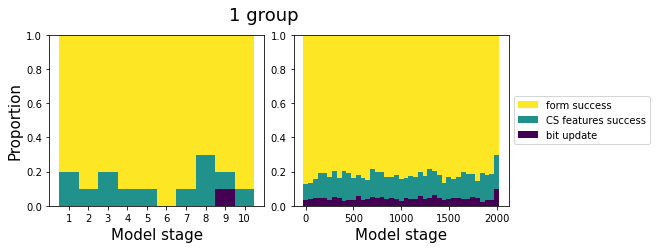

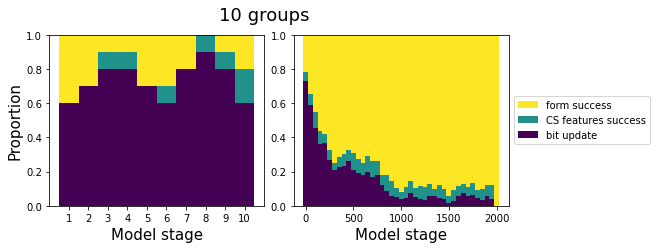

In [27]:
%matplotlib inline

plot_single_sim(df_model_output_1_group, "1 group", "barplot_1_group.png")

plot_single_sim(df_model_output_10_groups, "10 groups", "barplot_10_groups.png")

**Exercise 3:**

Run two simulations, both with ```n_groups = 5```, in which instead of varying the number of groups in the population, you instead vary the ```initial_degree_of_overlap``` parameter. Try out what happens with the following settings:
- ```initial_degree_of_overlap``` = 0.3
- ```initial_degree_of_overlap``` = 0.9

Plot what happens in the language games, just like we did above. Run the simulations a couple of times, and plot the results, to see what happens. Is there a simulation run in which you see a difference between the two conditions in the plots? If so, try and explain that difference.

I've copy-pasted the code cell with parameter settings from the top of the notebook below, so that you can easily change the parameters as needed:

In [28]:
################# PARAMETER SETTINGS: ################# 

test_params = dict(
    n_concepts=10, # int: number of concepts
    n_bits=10,  # int: number of bits (determining length of forms and culturally-salient feature vectors)
    n_agents=10, # int: number of agents in the population
    n_groups=1,  # determines how many different semantic groups there are
    initial_degree_of_overlap=0.9,  # degree of overlap between the form and meaning components
    n_steps=2000  # number of timesteps to run the simulation for (called "model stages" in the paper)
)

## Running a batch of simulations

Below we first need to set some extra parameters in order to:
- Run several conditions in which we vary the number of groups in the population (while keeping all other parameter settings constant)
- Run a number of independent simulation runs per condition (i.e., per setting of the ```n_groups``` parameter)

In [29]:
################# MORE PARAMETER SETTINGS: ################# 

# The code below turns n_groups into a variable parameter; to run several different settings in a batch run
variable_params = dict(n_groups=[1, 2, 5, 10]) # the different numbers of groups in the population to simulate separately
# need to do this because otherwise fixed_parameters overwrites variable_parameters:
fixed_params = dict((k, v) for (k, v) in test_params.items() if k not in variable_params)

n_iterations = 20  # number of independent simulation runs per condition (called "repetitions" in the paper)


In order to run a batch run with 4 different group sizes in a reasonable amount of time, we have to lower the ```n_iterations``` parameter (which determines how many independent simulation runs are run per condition) compared to the original paper. Mudd et al. (2022) used 100 runs per condition. This gives them a solid idea of how much variation there is between independent simulation runs (as some parts of the simulations are probabilistic/stochastic in nature). In the code cell above, I set ```n_iterations``` to 20. With this setting, the batch run below took about 5 minutes to run on my Macbook Pro which has a 2,6 GHz 6-Core Intel Core i7 processor. If the batch run still hasn't finished running after 10 minutes on your computer, consider decreasing the ```n_iterations``` parameter further; for example to 10.

Or, if you want to get a better idea of the variability between runs, and you have some time to wait for the simulations to finish running, you can increase the ```n_iterations``` parameter.

In [30]:
def create_batch_runner(model, variable_parameters=None, **kwargs):
    """ function created to circumvent problem of not having any variable_parameters
    even though mesa documentation says default of variable_parameters=None
    there is an error if None is passed... Yannick wrote mesa to fix this"""
    if not variable_parameters:
        return FixedBatchRunner(model, parameters_list=[], **kwargs)
    else:
        return BatchRunner(model, variable_parameters=variable_parameters, **kwargs)
    

In [31]:
def run_batch_sims(test_params, variable_params, fixed_params, n_iterations):

    start_time = time.time()
    
    br = create_batch_runner(ContextModel,
                         variable_parameters=variable_params,
                         fixed_parameters=fixed_params,
                         iterations=n_iterations,
                         max_steps=test_params["n_steps"]+1,  # set up = year 0 + x years
                         model_reporters={"Data Collector": lambda m: m.datacollector})

    br.run_all()
    br_df = br.get_model_vars_dataframe()  # df with params + data collector per run
    br_step_data = pd.DataFrame()

    for idx, row in br_df.iterrows():
        assert isinstance(row["Data Collector"], DataCollector)
        i_run_data = row["Data Collector"].get_model_vars_dataframe()
        i_run_data['idx'] = idx
        br_step_data = br_step_data.append(i_run_data, ignore_index=True)

    final_df = br_step_data.join(br_df.drop("Data Collector", axis="columns"), on='idx')
    final_df = final_df.rename(columns={"idx": "run"})
    
    print("Simulation(s) took %s minutes to run" % round(((time.time() - start_time) / 60.), 2))
    
    return final_df


We can use the run_batch_sims() function (and save the resulting dataframe to a .csv file) as follows:

In [32]:
final_df = run_batch_sims(test_params, variable_params, fixed_params, n_iterations)

final_df.to_csv(f"{csv_save_as}.csv")

/Users/U968195/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  
80it [07:10,  5.39s/it]


Simulation(s) took 7.2 minutes to run


Let's first inspect the resulting dataframe:

In [33]:
final_df

,pop_iconicity,pop_lex_var,current_step,lg_form_success,lg_meaning_success,lg_bit_update,run,n_groups,Run,n_concepts,n_bits,n_agents,initial_degree_of_overlap,n_steps
0,0.946,0.620000,0,NaN,NaN,NaN,0,1,0,10,10,10,0.9,2000
1,0.946,0.620000,1,8.0,2.0,0.0,0,1,0,10,10,10,0.9,2000
2,0.946,0.620000,2,9.0,1.0,0.0,0,1,0,10,10,10,0.9,2000
3,0.945,0.635556,3,8.0,1.0,1.0,0,1,0,10,10,10,0.9,2000
4,0.945,0.635556,4,9.0,1.0,0.0,0,1,0,10,10,10,0.9,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160075,0.567,0.555556,1996,7.0,1.0,2.0,79,10,79,10,10,10,0.9,2000
160076,0.567,0.555556,1997,10.0,0.0,0.0,79,10,79,10,10,10,0.9,2000
160077,0.567,0.555556,1998,9.0,0.0,1.0,79,10,79,10,10,10,0.9,2000
160078,0.568,0.544444,1999,7.0,1.0,2.0,79,10,79,10,10,10,0.9,2000


## Plotting the results of a batch of simulations

The code below plots the degrees of lexical variability and iconicity over time for each parameter setting included in your batch run. Given that we have now run 20 independent simulation runs per condition, the plots below show both the mean (dark line) and standard deviations (shaded areas) over those 20 independent runs. These plots are the same as Figure 10 in Mudd et al. (2022).

In [34]:
def plot_batch_sims(dataframe_batch_sims, filename, condition):

    # colormap
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # set up 2 column figure
    fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True)
    fig.set_size_inches(9, 4)

    # N_GROUPS
    # model_output = pd.read_csv("", index_col=0)  # pop_iconicity, pop_lex_var, year, run
    model_output = dataframe_batch_sims

    model_output = model_output[["pop_iconicity", "pop_lex_var", "current_step", "run", condition]]

    # lexical variability
    sns.set(style='whitegrid')
    sns.lineplot(data=model_output, x="current_step", y="pop_lex_var", hue=condition, ci="sd", palette=[cmaplist[0], cmaplist[85], cmaplist[170], cmaplist[-1]], ax=ax0)  # len(cmaplist)/3 = 85.33
    # axes
    ax0.set_title("Lexical variability", fontsize=18)
    ax0.set_xlim(0,2000)
    ax0.set_xlabel("Model stage", fontsize=15)
    ax0.set_ylim(0,1)
    ax0.set_ylabel("Mean lexical variability", fontsize=15)
    ax0.get_legend().remove()

    # iconicity
    sns.set(style='whitegrid')
    sns.lineplot(data=model_output, x="current_step", y="pop_iconicity", hue=condition, ci="sd", palette=[cmaplist[0], cmaplist[85], cmaplist[170], cmaplist[-1]], ax=ax1)
    # axes
    ax1.set_title("Iconicity", fontsize=18)
    ax1.set_xlim(0,2000)
    ax1.set_xlabel("Model stage", fontsize=15)
    ax1.set_ylim(0,1)
    ax1.set_ylabel("Mean iconicity", fontsize=15)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=condition)  # Add a legend

    plt.savefig(filename, dpi=1000, bbox_inches="tight")
    
    

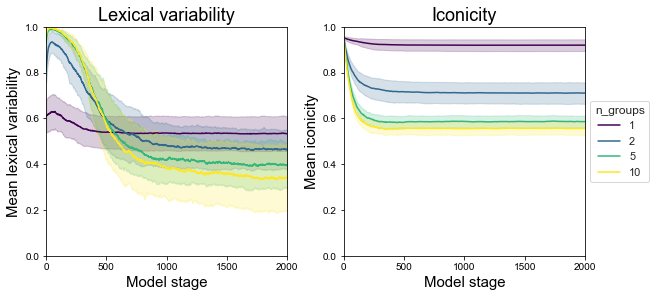

In [35]:
%matplotlib inline

condition = "n_groups"

plot_batch_sims(final_df, "n_groups_plt.png", condition)

**Exercise 4:**

Perform a batch run like the one above, but instead of varying the ```n_groups``` parameter, vary the  ```initial_degree_of_overlap``` parameter instead, using the following values:
- ```initial_degree_of_overlap = 0.1```
- ```initial_degree_of_overlap = 0.3```
- ```initial_degree_of_overlap = 0.6```
- ```initial_degree_of_overlap = 0.9```

Throughout each of these simulations, fix the value of the ```n_groups``` parameter at 5.

Plot the results of your batch run using the plotting code above (which plots the degree of lexical variability and the degree of iconicity for each of the four different parameter settings together).

**a)** Describe the differences that you see as a result of the different settings and ```initial_degree_of_overlap``` parameter, and try to explain them. 

**b)** (Conceptual question:) In what ways is manipulating the ```initial_degree_of_overlap``` parameter in this model different from manipulating the ```n_groups``` parameter? And in what ways might they be getting at the same thing?

To help you along with the first step, I've copy-pasted the two code cells with parameter settings below. The first code cell allows you to change the fixed parameters, and the second code cells allows you to change the variable parameters, which should be varied in the batch run. In the simulation above, the ```variable_params``` dictionary was used to vary the ```n_groups``` parameter, but for Exercise 4, you want to vary the ```initial_degree_of_overlap``` parameter instead.

In [1]:
################# PARAMETER SETTINGS: ################# 

test_params = dict(
    n_concepts=10, # int: number of concepts
    n_bits=10,  # int: number of bits (determining length of forms and culturally-salient feature vectors)
    n_agents=10, # int: number of agents in the population
    n_groups=1,  # determines how many different semantic groups there are
    initial_degree_of_overlap=0.9,  # degree of overlap between the form and meaning components
    n_steps=2000  # number of timesteps to run the simulation for (called "model stages" in the paper)
)

In [2]:
################# MORE PARAMETER SETTINGS: ################# 

# The code below turns n_groups into a variable parameter; to run several different settings in a batch run
variable_params = dict(n_groups=[1, 2, 5, 10]) # the different numbers of groups in the population to simulate separately
# need to do this because otherwise fixed_parameters overwrites variable_parameters:
fixed_params = dict((k, v) for (k, v) in test_params.items() if k not in variable_params)

n_iterations = 20  # number of independent simulation runs per condition (called "repetitions" in the paper)

If you're working in a virtual environment, **don't forget to deactivate your virtual environment** using the ```deactivate``` command.